# Compute displacement/momentum thickness

In [1]:
%%capture
# Important header information
naluhelperdir = '/projects/AWAKEN/lcheung/awaken.github/naluhelperscripts/'
#naluhelperdir = '/ascldap/users/lcheung/local/Git/naluhelperscripts/'

# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, naluhelperdir)
from numpy import *
import pickle

from matplotlib import animation
from IPython.display import HTML
import plotSamplePlaneGUI as pplane
import avgSamplePlanes as avgplane

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
rotorD = 127
A      = np.pi/4*rotorD**2  # Rotor Area
zHH    = 90
x0     = 2000
y0     = 2560
writeoutputs = True
datadir= 'data/'

In [3]:
turbineDir   = '/pscratch/mlblayl/AWAKEN/Neutral_Turbine_Yaw'
precursorDir = '/pscratch/mlblayl/AWAKEN/Neutral_NoTurbine_Yaw'

In [4]:
expr      = 'sqrt(velocity_probe[0]**2 + velocity_probe[1]**2)'
planenum  = 0
colormap  = 'coolwarm'
nlevels   = 101
clevels   = np.linspace(0, 10, nlevels)

In [5]:
def calcDelta(x, y, U, Uinf):
    xvec = x[0,:]
    yvec = y[:,0]
    deltaInt = 1.0 - U/Uinf
    delta = np.trapz(np.trapz(deltaInt, yvec, axis=0), xvec, axis=0)
    return delta

def calcTheta(x, y, U, Uinf):
    xvec = x[0,:]
    yvec = y[:,0]
    thetaInt = U/Uinf*(1.0 - U/Uinf)
    theta = np.trapz(np.trapz(thetaInt, yvec, axis=0), xvec, axis=0)
    return theta

-10.000000 0.007829 0.007771 1.007507
-8.000000 0.017446 0.016763 1.040749
-6.000000 0.032389 0.031450 1.029862
-4.000000 0.066088 0.063849 1.035076
-2.000000 0.143849 0.140639 1.022820
0.000000 0.250723 0.113501 2.208993
2.000000 0.460729 0.200102 2.302470
4.000000 0.485225 0.331543 1.463535
6.000000 0.468358 0.364957 1.283324
8.000000 0.432474 0.356254 1.213948
10.000000 0.399569 0.340642 1.172987
12.000000 0.364263 0.320759 1.135629
14.000000 0.333784 0.299880 1.113057
16.000000 0.293739 0.268981 1.092044
18.000000 0.256206 0.237931 1.076812
20.000000 0.240921 0.224905 1.071215


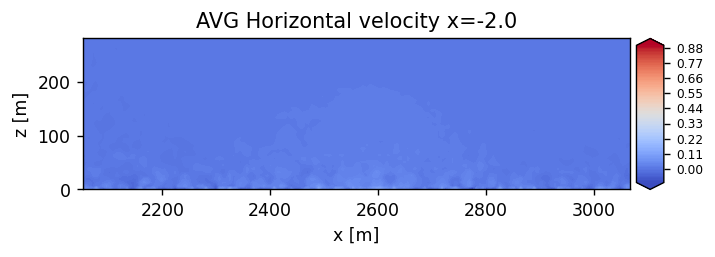

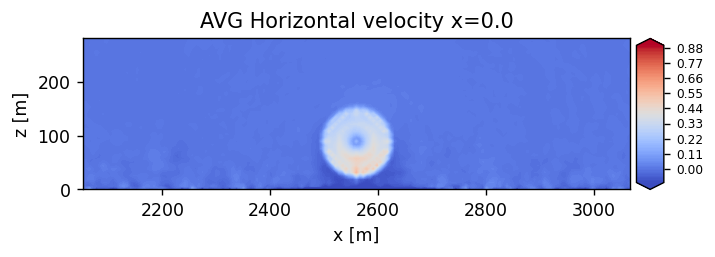

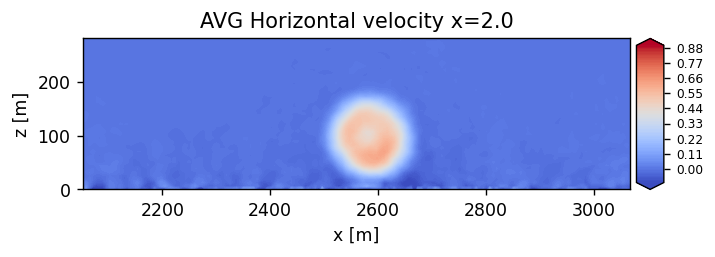

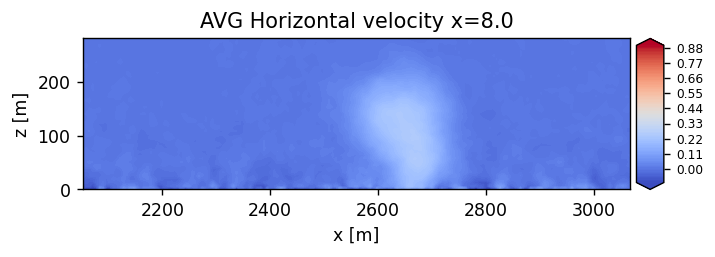

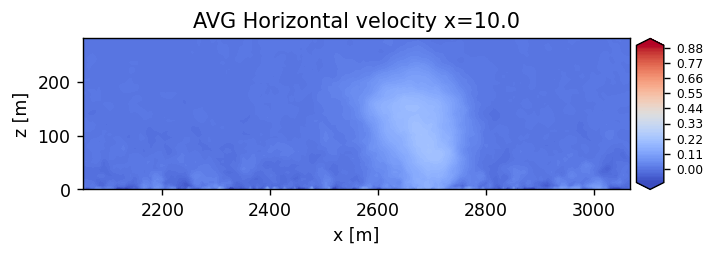

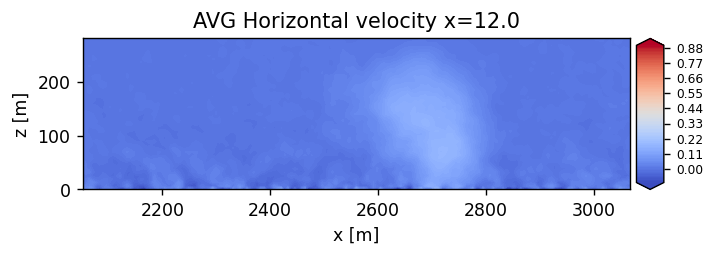

In [6]:
plotplanes = [-2, 0, 2, 8, 10, 12]
allplanes  = np.arange(-10,21,2)
#clevels = np.linspace(-0.1, 0.9, 101
dlevels = np.linspace(-0.1, 0.9, 101)

xlist = []
deltalist = []
thetalist = []
Hlist     = []

for iplane in allplanes:
    planefile='Nalu_Neutral_YZslice_%02iD_long.dat'%iplane
    noturbfile='Nalu_Neutral_NT_YZslice_%02iD_long.dat'%iplane
    
    turb_avgdat, time, turb_headers=pplane.loadplanefile(turbineDir+'/'+planefile, checkcomma=False)
    noturb_avgdat, time, noturb_headers=pplane.loadplanefile(precursorDir+'/'+noturbfile, checkcomma=False)
    Z1,Y1,Uturb = pplane.getplotplane(turb_avgdat,   planenum, 6, expr=expr, headers=turb_headers, xycol=[4,5])
    Z2,Y2,Upre  = pplane.getplotplane(noturb_avgdat, planenum, 6, expr=expr, headers=noturb_headers, xycol=[4,5])
    
    deltaXY = 1 - Uturb/Upre
    delta = calcDelta(Y1, Z1, Uturb, Upre)
    theta = calcTheta(Y1, Z1, Uturb, Upre)
    H     = delta/theta
    print('%f %f %f %f'%(iplane, delta/A, theta/A, H))
    xlist.append(iplane)
    deltalist.append(delta)
    thetalist.append(theta)
    Hlist.append(H)
    
    if iplane in plotplanes:
        fig, ax = plt.subplots(1,1,figsize=(6,3), dpi=125)
        #c = plt.contourf(Y1, Z1, Uturb/Upre, levels=41, cmap='coolwarm', extend='both')
        c = plt.contourf(Y1, Z1, deltaXY, levels=dlevels, cmap='coolwarm', extend='both')
        #c = plt.contourf(Y1, Z1, deltaXY, levels=dlevels, cmap='coolwarm', extend='both')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar=fig.colorbar(c, ax=ax, cax=cax)
        cbar.ax.tick_params(labelsize=7)
        ax.axis('scaled')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('z [m]')
        ax.set_title('AVG Horizontal velocity x=%0.1f'%(iplane))

In [7]:
# Save the data
if writeoutputs:
        savedat = np.vstack((np.array(xlist), np.array(deltalist)/A, np.array(thetalist)/A, np.array(Hlist),))
        fname   = f'NALUWIND_DeltaThetaH_Thickness.dat'
        np.savetxt(datadir+'/'+fname, savedat.transpose(), header="X/D Delta/A Theta/A H")